# Part 1

## 1.Read in the rating file and create an RDD consisting of parsed lines, then count the number of ratings.

In [1]:
from pyspark import SparkContext

# 获取当前活跃的 SparkContext 或创建一个新的
sc = SparkContext.getOrCreate()

ratings_rdd = sc.textFile("dataset/ratings.csv")
header = ratings_rdd.first()

# 去除头部，然后解析每一行
ratings_rdd = ratings_rdd.filter(lambda line: line != header) \
    .map(lambda line: line.split(',')) \
    .map(lambda tokens: (tokens[0], tokens[1], float(tokens[2]), tokens[3]))

num_ratings = ratings_rdd.count()
print(num_ratings)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/18 12:44:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25000095


## 2. Recommend 5 movies with the highest average rating.

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieLens").getOrCreate()
ratings_df = spark.createDataFrame(ratings_rdd, ["userId", "movieId", "rating", "timestamp"])

# 计算每部电影的平均评分
avg_ratings_df = ratings_df.groupBy("movieId").avg("rating")

# 降序排列并选出前5部
top_movies = avg_ratings_df.orderBy("avg(rating)", ascending=False).limit(5)

top_movies.show()

+-------+-----------+
|movieId|avg(rating)|
+-------+-----------+
| 195549|        5.0|
| 195641|        5.0|
| 182345|        5.0|
| 169338|        5.0|
| 159048|        5.0|
+-------+-----------+



## 3. Other operations to enrich your data analysis.

## 4. Try to create visualizations to convey the insights.

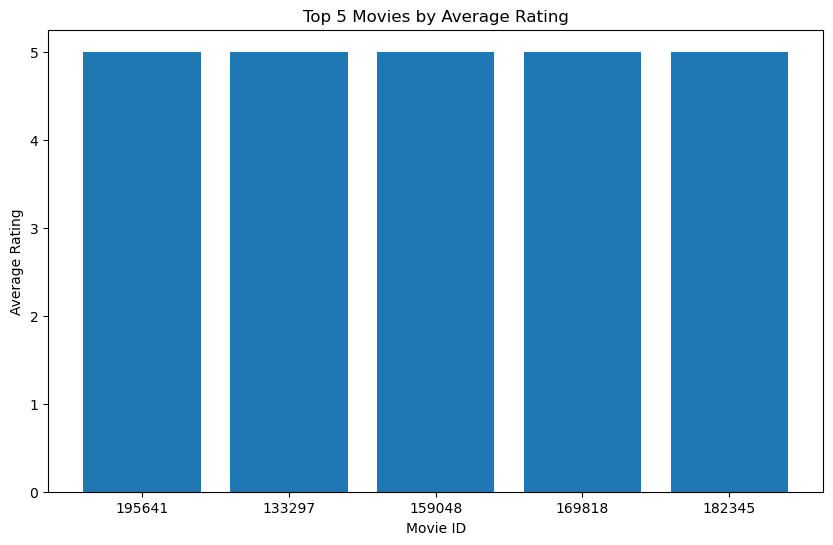

In [3]:
import matplotlib.pyplot as plt

# 以Pandas DataFrame的形式获取数据
top_movies_pd = top_movies.toPandas()

# 创建可视化
plt.figure(figsize=(10, 6))
plt.bar(top_movies_pd['movieId'], top_movies_pd['avg(rating)'])
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.title('Top 5 Movies by Average Rating')
plt.show()

# Part2

## 1. First split rating data into 70% training set and 30% testing set.

In [4]:
from pyspark.sql import Row

ratings_ml = ratings_df.rdd.map(lambda r: Row(userId=int(r[0]), movieId=int(r[1]), rating=float(r[2])))
ratings_ml_df = spark.createDataFrame(ratings_ml)

# 划分数据集
(training, test) = ratings_ml_df.randomSplit([0.7, 0.3])

23/11/18 12:45:24 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 9 (TID 81): Attempting to kill Python Worker


## 2. Choose one matrix factorization algorithm to predict the rating score based on the rating data file only.

In [ ]:
from pyspark.ml.recommendation import ALS

# 使用MLlib中的ALS（交替最小二乘法）算法进行评分预测是一个常见选择。
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

# 在测试集上进行预测
predictions = model.transform(test)

## 3. Extract features from movies and users (join movie and user data and do some feature transformation), then build another machine learning model to predict rating scores for the testing set.

## 3.1 Read and integrate additional data

In [ ]:
# 读取额外的数据
tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
genome_scores_df = spark.read.csv("dataset/genome-scores.csv", header=True, inferSchema=True)
genome_tags_df = spark.read.csv("dataset/genome-tags.csv", header=True, inferSchema=True)

# 可能的特征转换
# 例如，对电影类型进行独热编码
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# 类型转换
stringIndexer = StringIndexer(inputCol="genres", outputCol="genresIndex")
model = stringIndexer.fit(movies_df)
indexed = model.transform(movies_df)

encoder = OneHotEncoder(inputCol="genresIndex", outputCol="genresVec")
movies_encoded = encoder.transform(indexed)


## 3.2 Feature engineering

In [ ]:
# 合并标签和评分数据
# 这里是一个简化的例子，具体实现可能更复杂
tag_features_df = tags_df.join(genome_scores_df, "movieId").join(genome_tags_df, "tagId")

# 将电影信息和标签特征合并
movie_features_df = movies_encoded.join(tag_features_df, "movieId")

# 合并用户评分和电影特征
complete_data_df = ratings_ml_df.join(movie_features_df, "movieId")

## 3.3 Build and train machine learning models

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# 特征向量化
assembler = VectorAssembler(inputCols=["genresVec", "tagFeatures"], outputCol="features")
data_ready = assembler.transform(complete_data_df)

# 划分数据集
(training_features, test_features) = data_ready.randomSplit([0.7, 0.3])

# 使用随机森林模型
rf = RandomForestRegressor(featuresCol="features", labelCol="rating")
rf_model = rf.fit(training_features)

# 在测试集上进行预测
predictions_rf = rf_model.transform(test_features)

## 4. Compare the pros and cons of these two models and report it.

ALS模型:
+ 优点：适合大规模数据集，能有效处理稀疏性问题，常用于推荐系统。
+ 缺点：需要调整多个参数，对冷启动问题敏感。

随机森林模型:
+ 优点：处理非线性关系效果好，不太容易过拟合。
+ 缺点：需要大量特征工程，计算成本较高。

## 5. Try to create visualizations to convey the insights.

In [ ]:
import matplotlib.pyplot as plt

# 计算误差
predictions_pd = predictions.toPandas()
predictions_rf_pd = predictions_rf.toPandas()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(predictions_pd['rating'] - predictions_pd['prediction'], bins=20, color='blue', alpha=0.7)
plt.title('ALS Prediction Error')

plt.subplot(1, 2, 2)
plt.hist(predictions_rf_pd['rating'] - predictions_rf_pd['prediction'], bins=20, color='green', alpha=0.7)
plt.title('Random Forest Prediction Error')
plt.show()